In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


날씨 정보(최저 기온, 평균 기온, 최고 기온, 강수량)와 배추 가격은 어떤 상관 관계가 있는지 예측하는 AI를 만든다.  
최저 기온(minTemp), 평균 기온(avgTemp), 최고 기온(maxTemp), 강수량(rainFall)이 평균 배추 가격(avgPrice)에 영향을 미칠 경우 가격을 예측한다.
***
기상 정보: 기상자료개방포털(https://data.kma.go.kr) 가격 정보: 농산물유통정보(https://www.kamis.or.kr)

In [2]:
# price_data.csv 파일을 읽어 데이터프레임으로 저장한다.
price_data = pd.read_csv('./data/price_data.csv')
print(type(price_data))
price_data

<class 'pandas.core.frame.DataFrame'>


,year,avgTemp,minTemp,maxTemp,rainFall,avgPrice
0,20100101,-4.9,-11.0,0.9,0.0,2123
1,20100102,-3.1,-5.5,5.5,0.8,2123
2,20100103,-2.9,-6.9,1.4,0.0,2123
3,20100104,-1.8,-5.1,2.2,5.9,2020
4,20100105,-5.2,-8.7,-1.8,0.7,2060
...,...,...,...,...,...,...
2917,20171227,-3.9,-8.0,0.7,0.0,2865
2918,20171228,-1.5,-6.9,3.7,0.0,2884
2919,20171229,2.9,-2.1,8.0,0.0,2901
2920,20171230,2.9,-1.6,7.1,0.6,2901


In [3]:
# 데이터프레임에 저장된 데이터를 텐서플로우에서 처리하기에 적합하도록 넘파이 배열 형태로 변환한다.
data = np.array(price_data, dtype=np.float32)
print(type(data))
data

<class 'numpy.ndarray'>


array([[ 2.0100100e+07, -4.9000001e+00, -1.1000000e+01,  8.9999998e-01,
         0.0000000e+00,  2.1230000e+03],
       [ 2.0100102e+07, -3.0999999e+00, -5.5000000e+00,  5.5000000e+00,
         8.0000001e-01,  2.1230000e+03],
       [ 2.0100104e+07, -2.9000001e+00, -6.9000001e+00,  1.4000000e+00,
         0.0000000e+00,  2.1230000e+03],
       ...,
       [ 2.0171228e+07,  2.9000001e+00, -2.0999999e+00,  8.0000000e+00,
         0.0000000e+00,  2.9010000e+03],
       [ 2.0171230e+07,  2.9000001e+00, -1.6000000e+00,  7.0999999e+00,
         6.0000002e-01,  2.9010000e+03],
       [ 2.0171232e+07,  2.0999999e+00, -2.0000000e+00,  5.8000002e+00,
         4.0000001e-01,  2.9010000e+03]], dtype=float32)

In [4]:
# 넘파이 배열에서 변화 요인 데이터(평균 기온, 최저 기온, 최고 기온, 강수량)으로 사용할 데이터를 뽑아낸다.
xData = data[:, 1:5]
print(type(xData))
print(xData.ndim)
xData

<class 'numpy.ndarray'>
2


array([[ -4.9, -11. ,   0.9,   0. ],
       [ -3.1,  -5.5,   5.5,   0.8],
       [ -2.9,  -6.9,   1.4,   0. ],
       ...,
       [  2.9,  -2.1,   8. ,   0. ],
       [  2.9,  -1.6,   7.1,   0.6],
       [  2.1,  -2. ,   5.8,   0.4]], dtype=float32)

In [5]:
# 넘파이 배열에서 결과(평균 가격)로 사용할 데이터를 뽑아낸다. => 변화 요인이 2차원이므로 결과도 2차원으로 뽑아내야 한다.
# yData = data[:, 5] # 1차원 데이터로 뽑아낸다.
# data[:, 5]를 사용해서 1차원으로 뽑아냈으면 reshape() 함수를 사용해서 2차원으로 변환시켜야 한다.
# yData = yData.reshape(yData.shape[0], 1)
# yData = data[:, 5:6] # 슬라이싱을 실행하면 2차원 데이터로 뽑아낸다.
yData = data[:, [5]]
print(type(yData))
print(yData.ndim)
yData

<class 'numpy.ndarray'>
2


array([[2123.],
       [2123.],
       [2123.],
       ...,
       [2901.],
       [2901.],
       [2901.]], dtype=float32)

In [6]:
# 뽑아낸 데이터를 텐서플로우로 처리하기 위해서 placeholder를 만든다.
X = tf.placeholder(dtype=tf.float32, shape=[None, 4]) # 변화 요인을 기억하는 placeholder
Y = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # 평균 가격(실제값)을 기억하는 placeholder

In [7]:
# 다변인 선형 회귀 모델의 기울기와 y절편을 임의의 값으로 초기화 한다.
a = tf.Variable(tf.random_uniform([4, 1]), dtype=tf.float32) # 기울기, 4행 1열의 난수를 발생시킨다.
b = tf.Variable(tf.random_uniform([1]), dtype=tf.float32)    # y절편
sess = tf.Session()
sess.run(tf.global_variables_initializer())
print('a = {}, b = {}'.format(sess.run(a), sess.run(b)))

a = [[0.8594668 ]
 [0.6775793 ]
 [0.06021261]
 [0.29406905]], b = [0.16309845]


In [8]:
# 행렬의 적(곱셈) 연산을 이용해서 다변인 선형 회귀 모델의 가설 식을 세운다. => 예측값을 계산하는 식
y = tf.matmul(X, a) + b # 예측값
# 오차 함수를 만든다. => 예측값(y)과 실제값(Y)의 편차의 제곱에 대한 평균 => 평균 제곱법
loss = tf.reduce_mean(tf.square(y - Y))
# 경사 하강법 알고리즘을 사용해서 오차 함수의 결과를 최소로 하는 값을 찾는다.
gradient_descent = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [9]:
# 학습 시킨다.
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(100001):
    loss_, y_, _ = sess.run([loss, y, gradient_descent], feed_dict={X: xData, Y: yData})
    if i % 5000 == 0:
        print('Epoch: %6d, loss: %12.3f, y: %8.2f' % (i, loss_, y_[0]))

Epoch:      0, loss: 12414797.000, y:   -10.09
Epoch:   5000, loss:  1965990.250, y:  2649.72
Epoch:  10000, loss:  1873650.875, y:  2720.09
Epoch:  15000, loss:  1842603.750, y:  2771.74
Epoch:  20000, loss:  1831589.375, y:  2805.97
Epoch:  25000, loss:  1827613.625, y:  2827.65
Epoch:  30000, loss:  1826169.250, y:  2841.07
Epoch:  35000, loss:  1825644.125, y:  2849.28
Epoch:  40000, loss:  1825453.250, y:  2854.27
Epoch:  45000, loss:  1825383.750, y:  2857.29
Epoch:  50000, loss:  1825358.125, y:  2859.12
Epoch:  55000, loss:  1825349.000, y:  2860.22
Epoch:  60000, loss:  1825345.875, y:  2860.89
Epoch:  65000, loss:  1825344.875, y:  2861.29
Epoch:  70000, loss:  1825344.250, y:  2861.52
Epoch:  75000, loss:  1825344.000, y:  2861.69
Epoch:  80000, loss:  1825343.750, y:  2861.73
Epoch:  85000, loss:  1825343.750, y:  2861.74
Epoch:  90000, loss:  1825344.000, y:  2861.74
Epoch:  95000, loss:  1825344.000, y:  2861.74
Epoch: 100000, loss:  1825344.000, y:  2861.74


In [10]:
# 학습이 완료되면 학습된 모델을 디스크에 저장한다.
# Saver() 함수로 텐서플로우에서 학습된 모델을 디스크에 저장하거나 불러올때 사용할 객체를 생성한다.
saver = tf.train.Saver()
# save() 함수로 텐서플로우에서 학습된 모델을 디스크에 저장한다.
saver.save(sess, './model/saved.cpkt')
print('학습된 모델을 저장했습니다.')

학습된 모델을 저장했습니다.


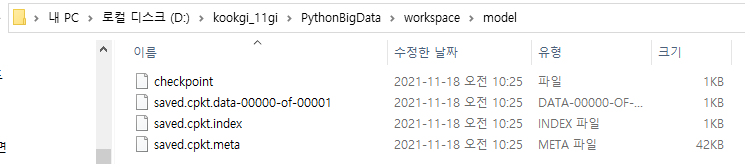

In [11]:
from IPython.display import Image
Image('./model/model.png', width=900)